# BrainStation Capstone Project: Predicting Covid News Sentiment with NLP
# Part 1: Data acquisition and EDA


**Date:      9/25/2022**  
**Author:  Eugene(Yen-Lin) Huang**  
**Part 1 of 3**

## Introduction

Text data has an increasing impact on today's world. From twitter tweet, news reports, to movie reviews, there is a vast amount of information incorporated in everyday texts. With the development of the Natural Language Processing(NLP) techniques, people can now extract information from texts more efficiently than ever before. In this project, I explore different ways to process the text data with NLP and predict the sentiment of Covid news articles. The main focus for this project is on applying different processing methods to the text data and see how well a model can perform just using the information from texts alone, although I do run a quick grid search at the very end as well to see how much the model can be improved by adding other features such as authors and news sources.

The choice to focus on the text itself is two folds. First, the motivation for me to start this project really stems from the interest of extracting information from the text data. Imagine we include all available features out there into our model and find that the most predictive features of the article sentiment are certain authors or news sources, then I would not know how much my text processing had helped predicting the sentiment, which is what I am interested to know about. Second, by focusing on the texts first, we can first find the optimal embedding/vectorization to process the text, then move forward for further modeling.  

Throughout this project, there are 4 different vectorization/embedding methods that I use to process the data, including the basic bag-of-words count-vectorizer, TF-IDF vectorization, a Word2Vec embedding trained by my own neural network, and a more refined LexVec embedding that was trained using all English Wikipedia texts. For each vectorization method, I try to fit the model to three different machine learning models with hyperparameter optimization. The models I tried include logistic regression,  decision tree, and KNN. In general, the best performing model across all vectorization methods is logistic regression, with which I have achieved about 65% prediction accuracy rate for my best model using the vectorized text alone. Also, perhaps surprisingly, TF-IDF vectorization outperforms both word2vec embeddings that I tried and is the best vectorization method among all alternatives in this project. 

This project spans across three different notebooks. The first one goes through the data acquisition and cleaning process as well as some preliminary EDA, the second demonstrates my modeling process, and the third shows my work on training my own word2vec embedding using neural network.

To kick off the first notebook, let's import some necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
#from bs4 import BeautifulSoup
#import nltk
#from nltk.corpus import stopwords  #import stopwords list
#nltk.download('stopwords')

import jsonlines
import re
from datetime import datetime

## The Covid News Dataset

This dataset is aquired from AYLIEN News API website, which can be requested [here](https://aylien.com/resources/datasets/coronavirus-dataset). The data would require an email sign up before it's available. I am not able to share it due to the potential copyright issue(also, the data has 25+ GB and exceeds my google drive limit). However, at the end of this notebook, I will come up with a cleaned subsample that I use in my following modeling work. The link for the subsample will be shared in the corresponding notebooks.


The original data is provided in JSONL format, from which I will extract the following features:

`Source`: The source media of the article

`Date`: The publication date of the article 

`Headline`: The headline of the article

`Author`: The author of the article

`Main Location`: The location of the publishing media

`Language`: The language the article is written with 

`Body`: The full text of the article

`Title`: Title of the article

`Language`: The language the article is written with 

`Sentiment_Body`: The categorical sentiment of the article

`Sentiment_Body_Score`: The confidence level of the Sentiment_Body category

`Sentiment_Title`: The categorical sentiment of the article title

`Sentiment_Title_Score`: The confidence level of the Sentiment_Title category

Below I will show how I extract the data from the JSONL file.

In [2]:
# create empty lists to store values extracted from the JSONL file
Source = list()
Date = list()
Headline = list()
Author = list()
Main_Location = list()
Language = list()
Body = list()
Sentiment_Body = list()
Sentiment_Body_Score = list()
Sentiment_Title = list()
Sentiment_Title_Score = list()

Now let's load the data into lists...

In [3]:
i = 0 #Just a counter I use to print out after each iteration to keep track of the progress
with jsonlines.open('data/aylien_covid_news_data.jsonl') as f: #read the jsonl file
    # jsonlines.open is an iterable object, with each line representing one entry of the data
    for article in f.iter():
        i+=1
        #Extract the required information by specifying the correct keys
        Source.append(article['source']['name'])
        Date.append(article['published_at'][0:10])
        #date = datetime.strptime(article['published_at'][0:10], '%Y-%m-%d')
        #Year.append(date.year)
        #Month.append(date.month)
        #Day.append(date.day)
        Headline.append(article['title'])
        Author.append(article['author']['name'])
        
        try:
            Main_Location.append(article['source']['locations'][0]['country'])
        except IndexError: # This happens when there is no location information so the list is empty
            Main_Location.append(None)
        
        Language.append(article['language'])
        bodytext = article['body'].replace('\xa0', ' ').replace('\n', ' ')
        bodytext = " ".join(bodytext.split()) #Replace multiple white spaces with single white space
        Body.append(bodytext)
        
        try:
            Sentiment_Body.append(article['sentiment']['body']['polarity'])
        except TypeError: #This happens when there is no sentiment information for the article
            Sentiment_Body.append(None)
            
        try:
            Sentiment_Body_Score.append(article['sentiment']['body']['score'])
        except TypeError: #This happens when there is no sentiment information for the article
            Sentiment_Body_Score.append(None)
            
        try:
            Sentiment_Title.append(article['sentiment']['title']['polarity'])
        except TypeError: #This happens when there is no sentiment information for the article
            Sentiment_Title.append(None)
            
        try:
            Sentiment_Title_Score.append(article['sentiment']['title']['score'])
        except TypeError: #This happens when there is no sentiment information for the article
            Sentiment_Title_Score.append(None)
            
        if i%10 !=0:
            continue
        print(f'Entry {i-9}-{i} appended...', end='\r')

Now let's put each list(columns) in a pandas dataframe.

In [4]:
covid_df = pd.DataFrame(data = {'Source': Source,
                                'Date': Date,
                                'Headline': Headline,
                                'Author': Author,
                                'Main_Location': Main_Location,
                                'Language': Language,
                                'Body': Body,
                                'Sentiment_Body': Sentiment_Body,
                                'Sentiment_Body_Score': Sentiment_Body_Score,
                                'Sentiment_Title': Sentiment_Title,
                                'Sentiment_Title_Score': Sentiment_Title_Score,
                                        })

Create an "id" column and show a few rows of the dataframe

In [5]:
# Create a new column order (to put 'id' at the first column)
old_column = [i for i in covid_df.columns]
new_column = ['id']
new_column.extend(old_column)

covid_df['id']=covid_df.index+1
covid_df = covid_df[new_column]

In [6]:
covid_df.head()

,id,Source,Date,Headline,Author,Main_Location,Language,Body,Sentiment_Body,Sentiment_Body_Score,Sentiment_Title,Sentiment_Title_Score
0,1,Complex,2020-04-05,British Prime Minister Boris Johnson Hospitali...,Gavin Evans,US,en,"On Sunday, British Prime Minister Boris Johnso...",positive,0.962804,neutral,0.863030
1,2,SBS,2020-04-05,NSW coronavirus death toll hits 18 as cases ri...,Australia,AU,en,NSW has now recorded 18 COVID-19 deaths as the...,negative,0.582620,neutral,0.575629
2,3,Hindustan Times,2020-04-05,Industry in Chandigarh will need major impetus...,Ht Correspondent,IN,en,ChandigarhWith shops and manufacturing units c...,negative,0.946297,neutral,0.845349
3,4,Hindustan Times,2020-04-05,"Coronavirus in Chandigarh: Follow advisories, ...",Amanjeet Singh Salyal,IN,en,"Chandigarh The 23-year-old man, discharged fro...",positive,0.975812,neutral,0.834398
4,5,Hindustan Times,2020-04-05,Crackers sound jarring note as Chandigarh tric...,Ht Correspondent,IN,en,CHANDIGARH The stillness which had become so m...,positive,0.509609,neutral,0.644154


In [7]:
covid_df['Author'][covid_df['Author']==''] = None

In [8]:
print(f'The constructed dataframe has {covid_df.shape[1]} features and {covid_df.shape[0]} rows, with each row representing 1 article.')

The constructed dataframe has 12 features and 1673353 rows, with each row representing 1 article.


Now that we have loaded the data, let's start doing some data cleaning and EDA.

## Data Cleaning

First, we will look at the info of the dataframe:

In [9]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1673353 entries, 0 to 1673352
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     1673353 non-null  int64  
 1   Source                 1673353 non-null  object 
 2   Date                   1673353 non-null  object 
 3   Headline               1673353 non-null  object 
 4   Author                 1476772 non-null  object 
 5   Main_Location          1183286 non-null  object 
 6   Language               1673353 non-null  object 
 7   Body                   1673353 non-null  object 
 8   Sentiment_Body         1673177 non-null  object 
 9   Sentiment_Body_Score   1673177 non-null  float64
 10  Sentiment_Title        1673182 non-null  object 
 11  Sentiment_Title_Score  1673182 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 153.2+ MB


It seems that the `Date` column is not in the correct format. I will need to change it. Also, I would like to alter the `Sentiment_Body_Score` and `Sentiment_Title_Score` so that they can be considered a numeric score of the sentiment instead of just the confidence of the sentiment category classification.

### 1. Alter Some Columns

#### Alter the Sentiment Score Column

I will first alter the `Sentiment_Body_Score` column. The current numbers in this column indicates the confident level that the article belongs to the category described in `Sentiment_Body` instead of the "sentiment score" that I would like to have.

I will transform the `Sentiment_Body_Score` column in the following way:

     If the article sentiment category is positive:  New Sentiment_Body_Score = Sentiment_Body_Score
     If the article sentiment category is neutral: New Sentiment_Body_Score = 0
     If the article sentiment category is negative: New Sentiment_Body_Score = -Sentiment_Body_Score

This way, the transformed feature should be able to represent a quantied score for sentiment.

In [10]:
#execute the caluclation as mentioned above
sentiment_type_body = covid_df['Sentiment_Body'].map({'positive':1, 'negative':-1, 'neutral':0})
covid_df['Sentiment_Body_Score'] = covid_df['Sentiment_Body_Score']*sentiment_type_body 

sentiment_type_title = covid_df['Sentiment_Title'].map({'positive':1, 'negative':-1, 'neutral':0})
covid_df['Sentiment_Title_Score'] = covid_df['Sentiment_Title_Score']*sentiment_type_title

#### Change the Date Column to Datetime

In [11]:
covid_df['Date'] = pd.to_datetime(covid_df['Date'])

Next, I will deal with the potential missing values.

### 2. Check for Missing Values

From the dataframe information above, we can see there are some missing values in several columns. Let's take a look at the fraction of the missing values in each column: 

In [12]:
covid_df.isna().sum()/covid_df.shape[0]

id                       0.000000
Source                   0.000000
Date                     0.000000
Headline                 0.000000
Author                   0.117477
Main_Location            0.292865
Language                 0.000000
Body                     0.000000
Sentiment_Body           0.000105
Sentiment_Body_Score     0.000105
Sentiment_Title          0.000102
Sentiment_Title_Score    0.000102
dtype: float64

Since my analysis will focus on the sentiment of the text, I will start by dropping the rows with missing sentiments. These are only 0.01% of the sample, and my dataset is large enough so that I can afford to drop these observations.

In [13]:
#selecting the rows with non-missing sentiment in formation
no_miss_senti = (covid_df['Sentiment_Body'].notna()) & (covid_df['Sentiment_Body_Score'].notna()) \
                & (covid_df['Sentiment_Title'].notna()) & (covid_df['Sentiment_Title_Score'].notna())
            
#replace the old dataframe
covid_df=covid_df[no_miss_senti]
covid_df.isna().sum()/covid_df.shape[0]

id                       0.000000
Source                   0.000000
Date                     0.000000
Headline                 0.000000
Author                   0.117480
Main_Location            0.292868
Language                 0.000000
Body                     0.000000
Sentiment_Body           0.000000
Sentiment_Body_Score     0.000000
Sentiment_Title          0.000000
Sentiment_Title_Score    0.000000
dtype: float64

There are still some missing values for `Author` and `Main_Location`. I will first deal with `Author`. Since there is no reasonable way to impute the author of certain articles. I will fill in authors as "unknown". I do not drop these observations because other features might still be useful. For example, the text column may still be useful for predicting the sentiment.

In [14]:
na_author_index = covid_df[covid_df['Author'].isna()].index 
covid_df.loc[na_author_index, 'Author'] = 'unknown'
covid_df.loc[na_author_index, :].head()

,id,Source,Date,Headline,Author,Main_Location,Language,Body,Sentiment_Body,Sentiment_Body_Score,Sentiment_Title,Sentiment_Title_Score
17,18,Straits Times,2020-04-05,Ecuador city runs out of coffins amid coronavi...,unknown,None,en,QUITO (AFP) - Soaring numbers of coronavirus d...,negative,-0.822715,neutral,0.000000
18,19,CBS News,2020-04-05,Why John Dickerson wrote about acknowledging e...,unknown,US,en,Amid the confusion and anxiety of coronavirus ...,negative,-0.803157,negative,-0.673197
29,30,Times of India,2020-04-05,"26-year-old tests positive, cops say he is Tab...",unknown,IN,en,Ludhiana: A 26-year-old man from Rajgarh villa...,negative,-0.989647,neutral,0.000000
30,31,Times of India,2020-04-05,69-yr-old Shimlapuri woman is second casualty ...,unknown,IN,en,Ludhiana: A 69-year-old woman from Shimlapuri ...,negative,-0.955704,neutral,0.000000
32,33,Australian Broadcast Corporation (ABC) News On...,2020-04-05,Latest coronavirus cases in Tasmania linked to...,unknown,AU,en,Two more cases of coronavirus in Tasmania have...,negative,-0.614323,neutral,0.000000


In [17]:
covid_df.isna().sum()/covid_df.shape[0]

id                       0.000000
Source                   0.000000
Date                     0.000000
Headline                 0.000000
Author                   0.000000
Main_Location            0.292868
Language                 0.000000
Body                     0.000000
Sentiment_Body           0.000000
Sentiment_Body_Score     0.000000
Sentiment_Title          0.000000
Sentiment_Title_Score    0.000000
dtype: float64

Now, I will look at the missing `Main_Location` and see if I can impute that using the news sources. The idea is that if only part of the rows for a certain news source is missing location information, then I can impute the location using the other articles from the same source. I will start by exploring the source for these articles with missing location: 

In [16]:
na_location_index = covid_df[covid_df['Main_Location'].isna()].index 

source_list = covid_df.loc[na_location_index, 'Source'].unique() #np.array containing the unique source names for the missing locations

useful_source = list() #empty list created to store the sources where only part of the rows are missing location

#If there are any sources where only part of the rows are missing location, they will be appended to the list
for source in source_list:
    nomiss = covid_df[covid_df['Source']==source]['Main_Location'].notna().sum()
    if nomiss!=0:
        useful_source.append()
    else:
        pass

print(useful_source) #If there are any sources where only part of the rows are missing location, they will be printed here

[]


Unfortunately, all sources in the source list are missing location information for all their articles. However, I can still look at the source name, and some of them might include location/country information that I can impute manually.

In [18]:
source_list

array(['Ars Technica', 'ITV', 'Yahoo - Singapore', 'Straits Times',
       'UrduPoint', 'Sportskeeda', 'MSNBC', 'ET Tech', 'Hot New Hip Hop',
       'Reuters', 'The Times Of India', 'Stuff', "Linda Ikeji's Blog",
       'KOVR', 'Yahoo', 'KBS World Radio', 'Fortune', 'Vietnam Express',
       'CNET', 'ComicBook', 'KRLD', 'Seeking Alpha',
       'Wall Street Journal', 'The New York Times', 'Investing',
       'Hacker News', 'Yahoo7 News Australia', 'Dominion Post',
       'The Cointelegraph', 'Vanguard', 'The Hans - India', 'Zero Hedge',
       'Live Science', 'IndieWire', 'Kotaku', 'Houston Chronicle',
       'TechRadar', 'The A.V. Club', 'WFOR', 'Variety', 'The Motley Fool',
       'Goal.com', 'Hot Hip Hop News', 'ZDNet', 'Hacker Noon', 'Money',
       'ESPN US', 'Vice', '9to5Mac', 'The World Bank', 'Engadget',
       'Gizmodo', 'Science', 'Yahoo UK and Ireland', 'Phys.org', 'Time',
       'POPSUGAR', 'People.com', 'Vogue', 'ABS-CBN News', 'PC Mag',
       'The Verge', 'Refinery29', 'I

Looking at these sources, many of them are on-line sources, which makes sense why they do not have a specified location. However, some of these names seem to be the on-line version of some local news sources. 

I Googled the names in the above list and imputed the location using the information I found. I did not impute the location if the source is a multi-national media company, a website/blog, an international organization, or an academia journal. 

In [19]:
#Manually enter identifiable countries from the source names
SG_list = ['Yahoo - Singapore', 'Straits Times']
IR_list = ['Mehr News']
ES_list = ['La Vanguardia']
GT_list = ['Prensa Libre']
SK_list = ['Slovak Spectator']
JP_list = ['Nikkei Asian Review']
NG_list = ['Vanguard']
PK_list = ['UrduPoint']
US_list = ['MSNBC', 'Inc.', 'KOVR', 'KRLD', 'Variety', 'Wall Street Journal', 'The New York Times',\
             'Real Clear Politics', 'Houston Chronicle', 'ESPN US', 'WFOR', 'WWJ', 'Communications of the ACM', ]
GB_list = ['RadioTimes', 'ITV', 'Yahoo UK and Ireland', 'British Journal of Sports Medicine', 'BBC.com']
IN_list = ['Auto NDTV', 'The Times Of India', 'The Hans - India']
KR_list = ['KBS World Radio', 'Joongang Ilbo']
VN_list = ['Vietnam Express']
AU_list = ['Yahoo7 News Australia']
PH_list = ['ABS-CBN News']
CO_list = ['Yahoo - Colombia']
FR_list = ['Google - France']

#Identify the index for each news source and replace the location accordingly
for country in ['SG', 'IR', 'ES', 'GT', 'SK', 'JP', 'NG', 'PK', 'US', 'GB', 'IN', 'KR', 'VN', 'AU', 'PH', 'CO', 'FR']:
    globals()['NA_' + str(country) + '_index'] = \
          covid_df[covid_df['Source'].isin(globals()[str(country) + '_list'])].index.intersection(na_location_index)
    covid_df.loc[globals()['NA_' + str(country) + '_index'],'Main_Location']=country

Now, I'll check again about the missing values:

In [20]:
covid_df.isna().sum()/covid_df.shape[0]

id                       0.000000
Source                   0.000000
Date                     0.000000
Headline                 0.000000
Author                   0.000000
Main_Location            0.200994
Language                 0.000000
Body                     0.000000
Sentiment_Body           0.000000
Sentiment_Body_Score     0.000000
Sentiment_Title          0.000000
Sentiment_Title_Score    0.000000
dtype: float64

Still, 20% of the location is not identifiable. I will impute them with "NA". As the information in other features for these articles might still be useful.

In [23]:
#select the index of the rows where location is missing
na_location_index = covid_df[covid_df['Main_Location'].isna()].index 
#replace with 'N/A'
covid_df.loc[na_location_index,'Main_Location'] = 'N/A'

In [24]:
covid_df.isna().sum()/covid_df.shape[0]

id                       0.0
Source                   0.0
Date                     0.0
Headline                 0.0
Author                   0.0
Main_Location            0.0
Language                 0.0
Body                     0.0
Sentiment_Body           0.0
Sentiment_Body_Score     0.0
Sentiment_Title          0.0
Sentiment_Title_Score    0.0
dtype: float64

In [25]:
print(f'I have completed my data cleaning, and the final dataset contains {covid_df.shape[0]} articles.')

I have completed my data cleaning, and the final dataset contains 1673032 articles.


Now, I will start my EDA.

## EDA

### 1. Language

I would first like to confirm whether all articles are in English 

In [27]:
covid_df['Language'].value_counts()

en    1673032
Name: Language, dtype: int64

I have confirmed all articles in the data are in English

### 2. Country Characteristics

#### Number of articles in each country
Next, I will look at how many countries are there in my data, and what does the article distribution looks like.

In [28]:
num_country = len(covid_df['Main_Location'].value_counts())
print(f'There are {num_country} different countries in the dataset')

There are 50 different countries in the dataset


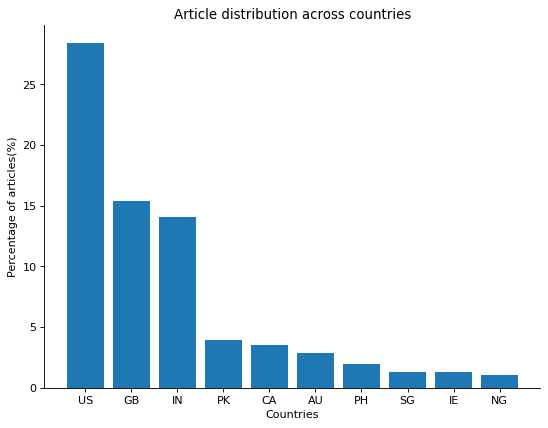

In [29]:
country_count = covid_df['Main_Location'].value_counts()  
country_count = country_count[country_count.index!='N/A'] #Excluding the articles without country information

#plotting the article distribution across countries
plt.figure(figsize=(8, 6), dpi=80)

plt.bar(country_count[:10].index, country_count[:10].round(4)*100/covid_df.shape[0])


sns.despine()
plt.xlabel('Countries')
plt.ylabel('Percentage of articles(%)')
plt.title('Article distribution across countries')

plt.show()

In [19]:
print((country_count[:20]*100/covid_df.shape[0]).round(2).astype(str)+'%') #Article distribution across countries

US    28.44%
GB    15.39%
IN    14.06%
PK     3.95%
CA     3.56%
AU      2.9%
PH     1.97%
SG     1.34%
IE     1.28%
NG     1.05%
RU     0.83%
NZ     0.79%
CN     0.69%
GH     0.55%
KE     0.55%
JP     0.35%
IT     0.34%
HK     0.33%
KR     0.27%
ZA     0.26%
Name: Main_Location, dtype: object


Unsurprisingly, most of the articles are from English-speaking countries.

28.44% of the articles are from the US, followed by 15.39% in the UK and 14.06% in India. Note that I am excluding the articles with unidentifiable source countries in this analysis, which accounts for about 20.09% of the articles in the dataset.  

#### Body Sentiment by Countries

It is also interesting to look at how sentiment varies across different countries.

For this analysis, I will focus on the top 20 countries with the most articles, which already covers more than 99% of articles with identifiable source countries.

In [30]:
Top20_country = [i for i in country_count[:20].index] #Selecting the top 20 countries with the most articles

I will first look at the categorical sentiments (positive, negative, neutral) by countries

In [32]:
df_top20_Country = covid_df[covid_df['Main_Location'].isin(country_count[:20].index)] #top 20 countries in Covid_df

#Distribution of body sentiment categories across countries
country_sentiment = df_top20_Country.groupby(['Main_Location', 'Sentiment_Body'])['Sentiment_Body'].count()/df_top20_Country.groupby(['Main_Location'])['Main_Location'].count()

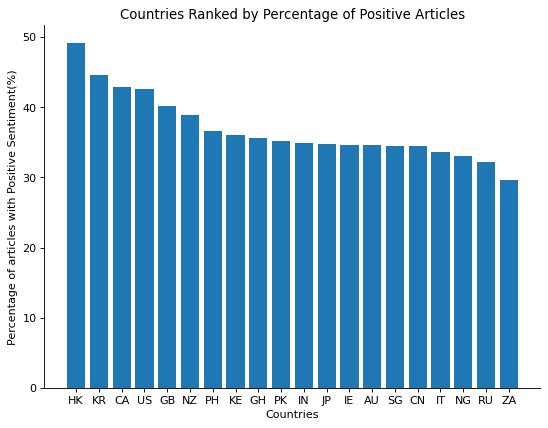

In [33]:
#Visualize the most positive countries 
poitive_scores = {country_sentiment[i][2]:i for i in Top20_country} 
sorted_scores = np.array(sorted(poitive_scores, reverse=True))

plt.figure(figsize=(8, 6), dpi=80)

plt.bar([poitive_scores[c] for c in sorted_scores], sorted_scores*100)

sns.despine()
plt.xlabel('Countries')
plt.ylabel('Percentage of articles with Positive Sentiment(%)')
plt.title('Countries Ranked by Percentage of Positive Articles')

plt.show()

The most positve country is Honkong, which has 49.3% of the articles being positive. The least positive country is South Africa(ZA), which has 26.5% of the articles being positive. I will also check the ranking by negative sentiments.

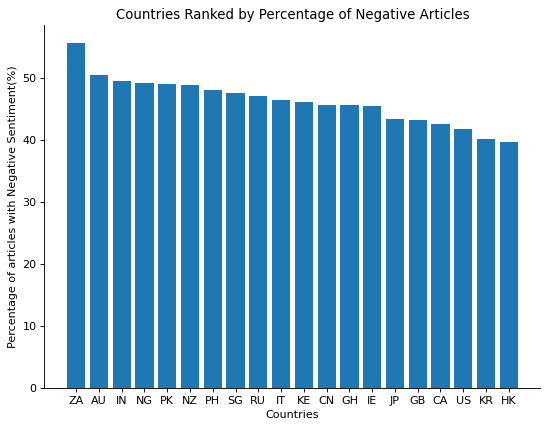

In [34]:
#Visualize the most negative countries 
negative_scores = {country_sentiment[i][0]:i for i in Top20_country} 
sorted_scores = np.array(sorted(negative_scores, reverse=True))

plt.figure(figsize=(8, 6), dpi=80)

plt.bar([negative_scores[c] for c in sorted_scores], sorted_scores*100)

sns.despine()
plt.xlabel('Countries')
plt.ylabel('Percentage of articles with Negative Sentiment(%)')
plt.title('Countries Ranked by Percentage of Negative Articles')

plt.show()

In terms of negative articles, South Africa also has the highest percentage, while Hong Kong, Canada, and the US remains the least negative countries. 

Next, I would like to check the numeric sentiment scores across the countries:

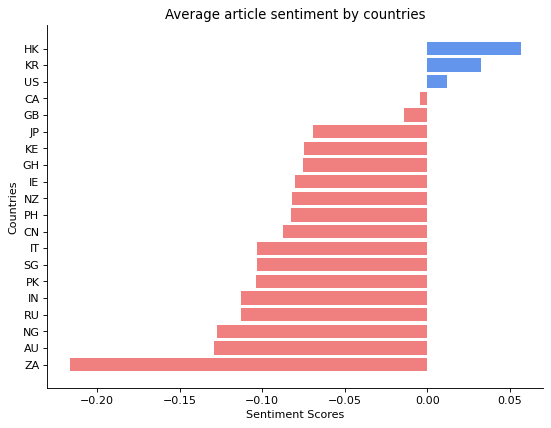

In [35]:
#Body sentiment scores by countries
body_score = df_top20_Country.groupby(['Main_Location'])['Sentiment_Body_Score'].mean().sort_values()

plt.figure(figsize=(8, 6), dpi=80)

plt.barh(body_score.index, body_score, color=['cornflowerblue' if i>0 else 'lightcoral' for i in body_score])

sns.despine()
plt.xlabel('Sentiment Scores')
plt.ylabel('Countries')
plt.title('Average article sentiment by countries')

plt.show()

Since the scores are scaled between -1 and 1, the above graph shows most countries have slightly negative sentiment on average, with Hong Kong, Korea, and the US being the only countries with positive average scores, and South Africa being the most negative country.

I will quickly do the same analysis for the title sentiment:

In [36]:
#Distribution of title sentiment categories across countries
country_sentiment_title = df_top20_Country.groupby(['Main_Location', 'Sentiment_Title'])['Sentiment_Title'].count()/df_top20_Country.groupby(['Main_Location'])['Main_Location'].count()

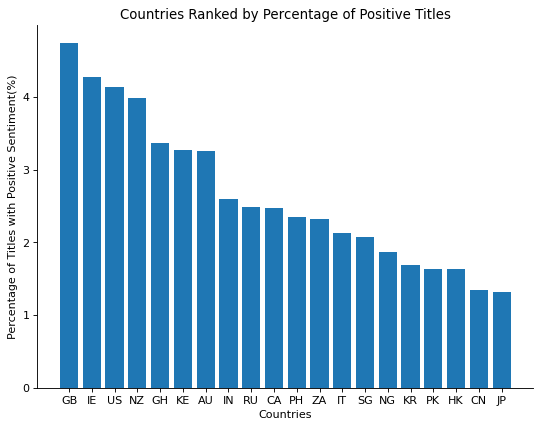

In [37]:
#Visualize the most positive countries 
poitive_scores = {country_sentiment_title[i][2]:i for i in Top20_country} 
sorted_scores = np.array(sorted(poitive_scores, reverse=True))

plt.figure(figsize=(8, 6), dpi=80)

plt.bar([poitive_scores[c] for c in sorted_scores], sorted_scores*100)

sns.despine()
plt.xlabel('Countries')
plt.ylabel('Percentage of Titles with Positive Sentiment(%)')
plt.title('Countries Ranked by Percentage of Positive Titles')

plt.show()

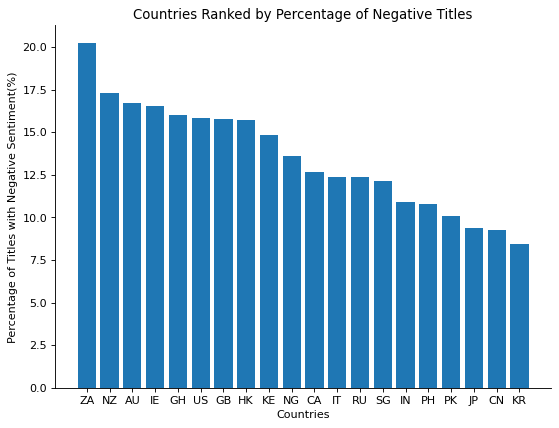

In [27]:
#Visualize the most negative countries 
negative_scores = {country_sentiment_title[i][0]:i for i in Top20_country} 
sorted_scores = np.array(sorted(negative_scores, reverse=True))

plt.figure(figsize=(8, 6), dpi=80)

plt.bar([negative_scores[c] for c in sorted_scores], sorted_scores*100)

sns.despine()
plt.xlabel('Countries')
plt.ylabel('Percentage of Titles with Negative Sentiment(%)')
plt.title('Countries Ranked by Percentage of Negative Titles')

plt.show()

Rankings of the title sentiment seems to be slightly different from that of the body sentiment. However, the percentage for positive and negatives are much lower than the body sentiment, suggesting that most of the article titles are labeled as neutral in sentiment.

I'll also look at the title sentiment scores:

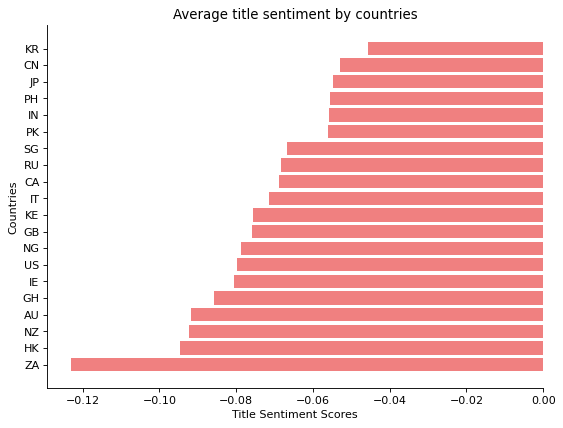

In [38]:
#Title sentiment scores by countries
title_score = df_top20_Country.groupby(['Main_Location'])['Sentiment_Title_Score'].mean().sort_values()

plt.figure(figsize=(8, 6), dpi=80)

plt.barh(title_score.index, title_score, color=['cornflowerblue' if i>0 else 'lightcoral' for i in title_score])

sns.despine()
plt.xlabel('Title Sentiment Scores')
plt.ylabel('Countries')
plt.title('Average title sentiment by countries')

plt.show()

Titles in all countries have negative sentiment score on average, but the general scale is smaller than the body. 

A quick look of the title sentiment here shows that the majority of the titles are neutral in sentiment. Moving forward, I will focus my analysis on the body sentiment. 

### 3. Article and Sentiment Trends

Next, I would like to explore how the number of COVID articles and their sentiment evolve across time.

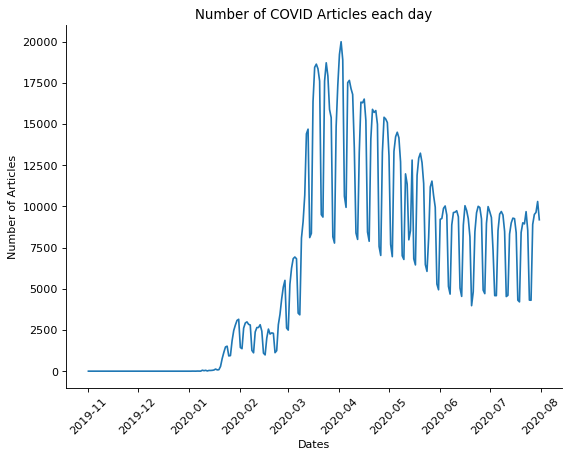

In [40]:
#count the number of articles by dates
date_count = covid_df.groupby('Date')['id'].count()

#plotting the number of articles by dates
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(date_count.index, date_count)

sns.despine()
plt.xlabel('Dates')
plt.ylabel('Number of Articles')
plt.xticks(rotation = 45)
plt.title('Number of COVID Articles each day')

plt.show()

Number of COVID articles around the world started low in late 2019, slightly increased in January, 2020, and then had a huge spike around March/April in 2020. After that, the number of articles gradually decreased to a somewhat stable levle around June, 2020. Note that there were some daily fluctuation in each month.

Next, I'll check how sentiment evolves across time. I will look at the sentiment at a less granular level(monthly).

In [41]:
monthly_df = pd.DataFrame(data = { 'Year_Month': covid_df['Date'].dt.to_period('M'),
                                   'Sentiment_Body': covid_df['Sentiment_Body'],
                                   'Sentiment_Body_Score': covid_df['Sentiment_Body_Score']
                                   })

#Percentage of categorical sentiment in each month
monthly_cat_count = monthly_df.groupby(['Year_Month','Sentiment_Body'])['Sentiment_Body'].count()/monthly_df.groupby(['Year_Month'])['Year_Month'].count()

#Monthly Sentiment Score
monthly_sentiment = monthly_df.groupby(['Year_Month'])['Sentiment_Body_Score'].mean()

#List of Year-Month
date_list = [i.strftime('%Y-%m') for i in monthly_df.groupby(['Year_Month'])['Year_Month'].count().index]


I will first visualize the percentage of articles in each sentiment category:

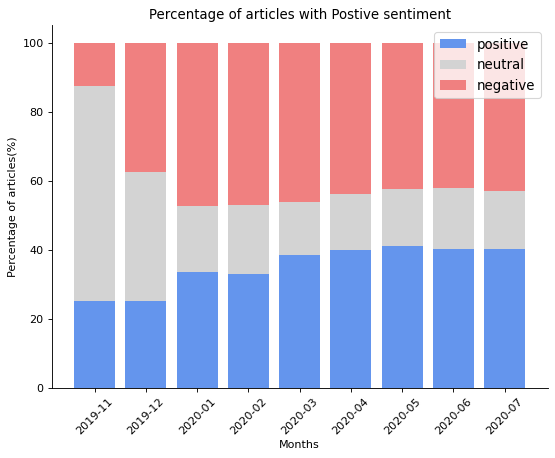

In [42]:
#Percentage of articles in each category:
poitive_pct = np.array([monthly_cat_count[i][2] for i in date_list]) 
neutral_pct = np.array([monthly_cat_count[i][1] for i in date_list]) 
negative_pct = np.array([monthly_cat_count[i][0] for i in date_list]) 

plt.figure(figsize=(8,6),dpi=80)

plt.bar(date_list, poitive_pct*100, color='cornflowerblue', label='positive')
plt.bar(date_list, neutral_pct*100, bottom=poitive_pct*100, color='lightgrey', label='neutral')
plt.bar(date_list, negative_pct*100, bottom=(neutral_pct*100+poitive_pct*100), color='lightcoral', label='negative')
sns.despine()
plt.legend(fontsize='large')
plt.xticks(rotation = 45)
plt.xlabel('Months')
plt.ylabel('Percentage of articles(%)')
plt.title('Percentage of articles with Postive sentiment')

plt.show()

The stacked bar chart above shows that most of the articles at the start of COVID (late 2019) hold a neutral attitude, with the rest of the articles lean towards a positive sentiment, while in 2020, the portion of articles with negative sentiment increased significantly, with fewer articles retaining a neutral attitude. The portion of positive articles also gradually increased throughout 2020.

I can also check the trend of the quantified sentiment scores:

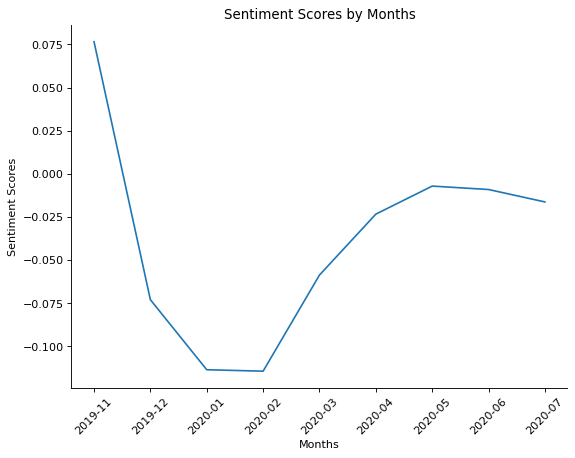

In [43]:
plt.figure(figsize=(8,6),dpi=80)

plt.plot(date_list, monthly_sentiment)

sns.despine()
plt.xlabel('Months')
plt.ylabel('Sentiment Scores')
plt.xticks(rotation = 45)
plt.title('Sentiment Scores by Months')

plt.show()

The sentiment scores also show a similar trend. The sentiment was positive at the start of the pandemic, turned negative in early 2020, and then slowly climbed back to neutral.

### 4. Sentiment from Different Sources

Next, I'd like to explore whether different news sources tend to have different sentiment towards COVID. First, let's look at the article distribution from different sources. I will visualize the percentage of articles from the top 50 sources.

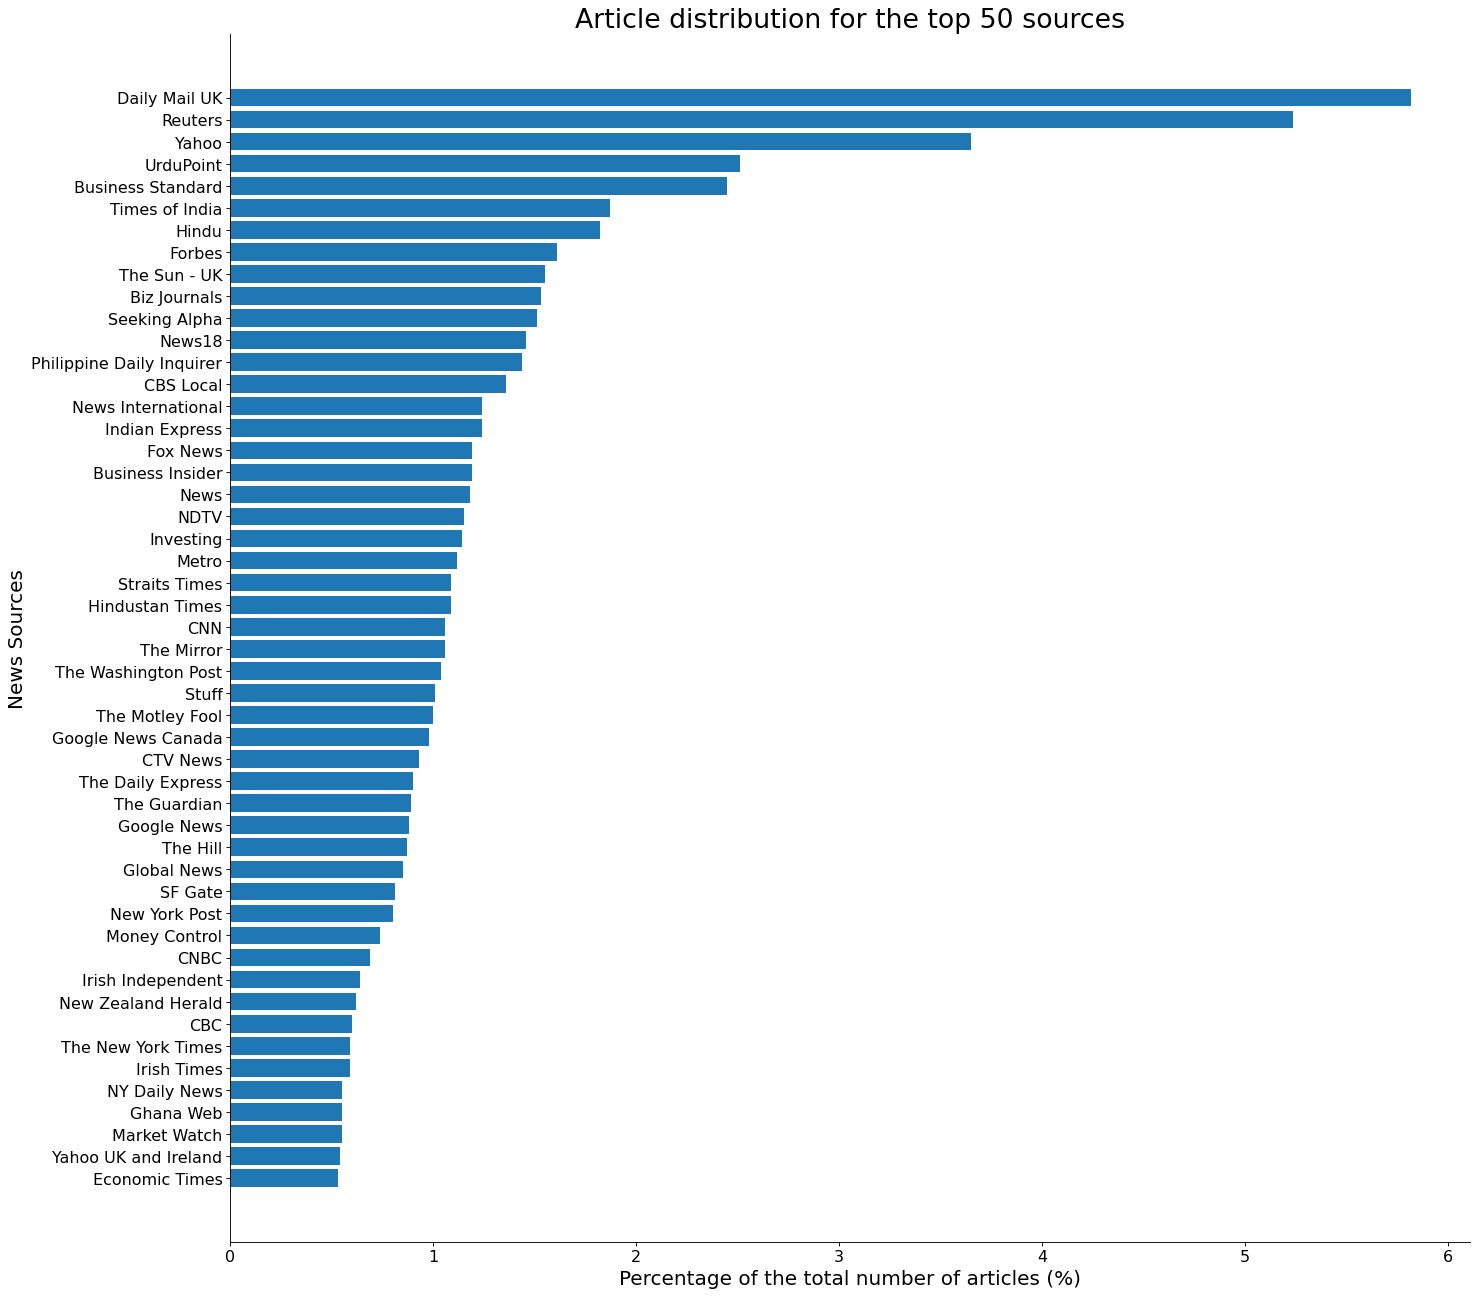

In [44]:
source_count = covid_df.groupby(['Source'])['Source'].count().sort_values(ascending=False) #article counts for each source
source_dist = (source_count/source_count.sum()).round(4)*100                               #article counts/total number of articles
top_50_source = source_dist.head(50)

plt.figure(figsize=(20, 20), dpi=80)

plt.barh(top_50_source.sort_values().index,top_50_source.sort_values())

sns.despine()
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Percentage of the total number of articles (%)', fontsize=18)
plt.ylabel('News Sources', fontsize=18)
plt.title('Article distribution for the top 50 sources', fontsize=24)

plt.show()


Aside from a few large sources, the articles distribute pretty evenly for different sources. My analysis here will focus on sources that account for more than 0.1% of all articles and see if we can observe different sentiment from different sources. 

To see if there is significant variation of sentiment across different news sources, I'd like to compare the top 10 sources that have the most positive articles with the bottom 10 sources that have the least positive article and see if there are significant differences. Since I expect I will repeat the same comparison later for sentiment across different authors, I would like to define a function for the task:

In [36]:
def sentiment_compare(feature, ent_list, categorical, pos_neg='positive'):
    '''
    This function compares cross-sectional difference of article sentiment. A user can specify a feature in covid_df,
    and this function will group the article sentiment by that feature and provide a visualized comparison of sentiment
    between the top-10 and bottom-10 categories of that feature.  
    
    Inputs:
        feature: String. Must match one of the column names in covid_df. Will group by this column and compare the 
                 cross-sectional sentiment difference.
        
        ent_list: The list of the categories included in the comparison. Must match the values of the column specified by 
                  'feature'.
        
        categorical: Boolean variable. True if comparing categorical sentiment, and False if comparing numeric sentiment score. 
        
        pos_neg: only needed if categorical=True. Specify whether the comparison is on positive or negative articles.
                 Default is 'positive'.
    
    Output:
        Print out a graph that compares the sentiment of the top 10 categories and the bottom 10 categories.(sorted by the 
        specified criteria)
    '''
    
    assert isinstance(feature, str), 'feature must be a string.'
    assert feature in covid_df.columns, 'The input feature is not a column in covid_df'
    assert isinstance(ent_list, list), 'ent_list must be a list.'
    assert set(ent_list).issubset(set(covid_df[feature].values)), 'ent_list must be a subset of values in the specified feature'
    assert isinstance(categorical, bool), 'categorical must be boolean'
    assert pos_neg in ['positive', 'negative', 'neutral'], 'pos_neg must be either positive, negative, or neutral'
    
    
    if categorical==True:
        #Extract categorical sentiment grouped by 'feature'
        col=[feature]
        col.append('Sentiment_Body')
        cat_count = covid_df.groupby(col)['Sentiment_Body'].count()/covid_df.groupby([feature])[feature].count()
        
        score = []
        for e in ent_list:
            try:
                score.append(cat_count[e][pos_neg])
            except:
                score.append(0)
        
        temp_df=pd.DataFrame(data={ 'Entity': ent_list,
                                    'Score': score})
        
        top_df = temp_df.sort_values(by='Score', ascending = False).head(10)
        bottom_df = temp_df.sort_values(by='Score').head(10)
        
        
        #Capitalize the 'pos_neg' string for better labeling of the graph
        c_pos_neg = pos_neg.capitalize()
        
        #plot the comparison
        plt.figure(figsize=(8,6))

        plt.bar(top_df['Entity'], top_df['Score']*100, label='top10', color='cornflowerblue')
        plt.bar(bottom_df['Entity'], bottom_df['Score']*100, label='bottom10', color='lightcoral')
        sns.despine()
        plt.xticks(rotation = 90, fontsize='large')
        plt.xlabel(f'{feature}', fontsize=12)
        plt.ylabel(f'{c_pos_neg} Articles (%)', fontsize=12)
        plt.title(f'Percentage of {c_pos_neg} Articles (Top 10 vs. Bottom 10)', fontsize=16)

        plt.legend(fontsize='large')
        plt.show()
    
    else:
        #Average sentiment scores by 'feature'
        cat_count = covid_df.groupby(feature)['Sentiment_Body_Score'].mean()
        top_10 = cat_count.sort_values(ascending=False).head(10)
        bottom_10 = cat_count.sort_values().head(10)
        
        #plot the comparison
        plt.figure(figsize=(8,6))

        plt.bar(top_10.index, top_10, label='top10', color='cornflowerblue')
        plt.bar(bottom_10.sort_values(ascending=False).index, bottom_10.sort_values(ascending=False), label='bottom10', color='lightcoral')
        sns.despine()
        plt.xticks(rotation = 90, fontsize='large')
        plt.xlabel(f'{feature}', fontsize=12)
        plt.ylabel(f'Sentiment Scores', fontsize=12)
        plt.title(f'Sentiment Scores by {feature} (Top 10 vs. Bottom 10)', fontsize=16)

        plt.legend(fontsize='large')
        plt.show()

The following graphs compare the sources with the most positive/negative articles with the ones with the least:

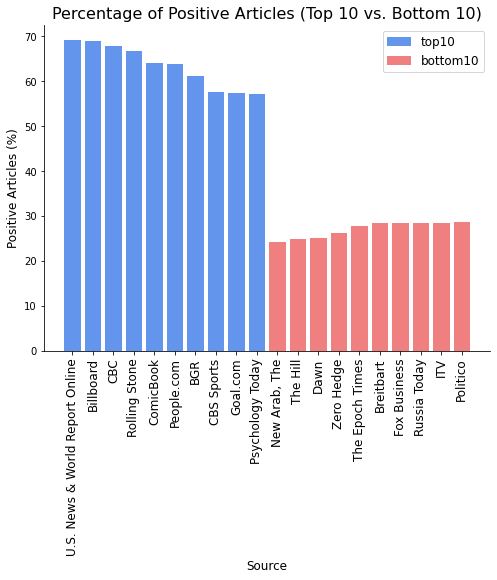

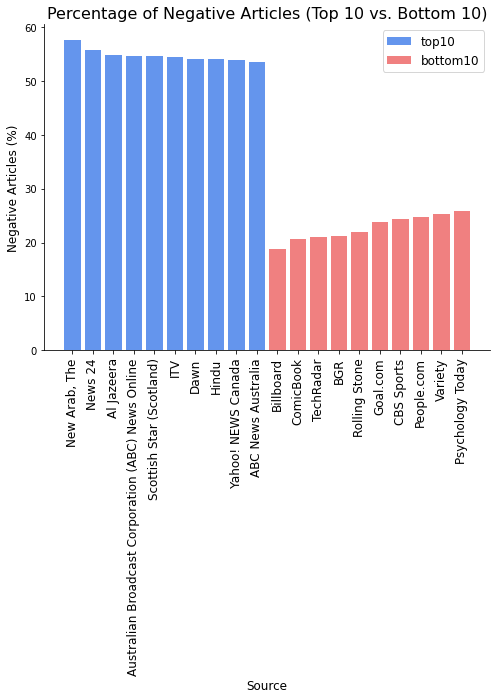

In [37]:
filtered_source = [i for i in source_dist[source_dist>0.1].index] #Drop the sources that account for less than 0.1% of the dataset

sentiment_compare('Source', filtered_source, True, pos_neg='positive')
sentiment_compare('Source', filtered_source, True, pos_neg='negative')

The above two graphs show significant variation of sentiment between different news sources. If we focus on the positive articles, the top 10 sources have about 60%-70% of the articles having a positive sentiment, while the ratio is only about 30% for the bottom 10 sources. The same analysis on the portion of negative articles shows similarly large difference.

I will also do a similar comparison on the numeric sentiment scores:

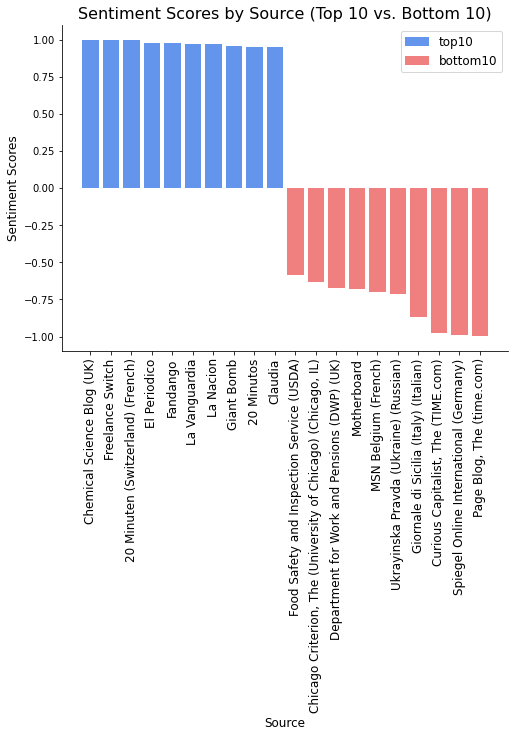

In [38]:
sentiment_compare('Source', filtered_source, False)

The chart above confirms that sentiment varies a lot between different sources. The average scores are very extreme for some of the sources. Recall that in my previous analyses, where the sentiment scores were grouped by months or countries, the average sentiment scores mostly fall between (-0.15, 0.15). Comparing to those numbers, the average sentiment scores for the top/bottom news sources are extreme, as they are close to the theoretical maximum/minimum of 1/-1.  

### 5. Sentiment from Different Authors

A first look at the `Author` column shows that some of the largest "authors" in the dataset is actually institution names:

In [45]:
covid_df['Author'].value_counts().drop(index='unknown')

Reuters              66117
Reuters Editorial    50013
Press Trust          22437
Associated Press     15091
Pti                  10874
                     ...  
Greg Shepard             1
Giri Devanur             1
Heather Cheney           1
Valentin Bolotnyy        1
Michael O'flynn          1
Name: Author, Length: 87754, dtype: int64

Without better ideas to impute the actual human authors, I will leave it as is for now and start my data cleaning for this column. I will first check how many names are in English letters as would be expected:

In [46]:
letter_index = covid_df['Author'].str.fullmatch('^[a-zA-Z\s\-\.\']+$').mean()
print(f'{round(letter_index*100, 2)}% of authors are in pure English letters with ".", "\'" or "-".')
letter_index = covid_df[covid_df['Author'].str.fullmatch('^[a-zA-Z\s\-\.\']+$')].index

95.91% of authors are in pure English letters with ".", "'" or "-".


The 'Author' column may require further cleaning. I will check several cases below.

First, let's deal with the names with a comma:

In [47]:
#The author names contain commas
comma_index = covid_df['Author'].str.contains(',')
comma_index = covid_df[comma_index].index
covid_df.loc[comma_index,'Author'].value_counts()

Staff Writer, Singapore                                                   668
Nikki Schwab,                                                             248
James Tapsfield,                                                          234
David Wilcock,                                                            233
Jack Maidment,                                                            232
                                                                         ... 
Ryan W. Miller, Jordan Culver, Joel Shannon And Erick Smith, Usa Today      1
Catherine Wylie, Pa                                                         1
By John Leicester, Associated Press                                         1
Sanya Burgess And Aubrey Allegretti, News And Politics Reporters            1
Jassar Al-tahat,                                                            1
Name: Author, Length: 6528, dtype: int64

For these observations, I would like to keep the words before the comma.

In [48]:
covid_df.loc[comma_index,'Author'] = covid_df.loc[comma_index, 'Author'].str.split(',').str[0].str.replace('By', '')
covid_df.loc[comma_index, :].head()

,id,Source,Date,Headline,Author,Main_Location,Language,Body,Sentiment_Body,Sentiment_Body_Score,Sentiment_Title,Sentiment_Title_Score
16,17,Yahoo - Singapore,2020-04-05,WEEKLY ROUND-UP: Sports happenings in Singapor...,Staff Writer,SG,en,SINGAPORE — Here is a round-up of sports event...,neutral,0.000000,neutral,0.0
196,197,Irish Independent,2020-04-05,Consumer confidence has plunged at fastest rat...,Vicky Shaw,IE,en,Consumer confidence fell of a cliff in the las...,neutral,0.000000,neutral,0.0
197,198,Irish Independent,2020-04-05,New overdraft rules in force but lenders adjus...,Vicky Shaw,IE,en,New overdraft rules come into force from Monda...,negative,-0.890937,neutral,0.0
204,205,UK Government,2020-04-05,Government and video games industry join force...,Department For Digital,GB,en,Government partners with leading UK video game...,positive,0.999320,neutral,0.0
266,267,Irish Independent,2020-04-05,Rita Ora praises her ‘superhero’ mother after ...,Tom Horton,IE,en,Rita Ora has praised her “superhero” psychiatr...,positive,0.887100,neutral,0.0


I will also check the names containing colons:

In [50]:
colon_index = covid_df['Author'].str.contains(':')
colon_index = covid_df[colon_index].index
covid_df.loc[colon_index,'Author'].value_counts()

Credit: Pa                                       876
Credit: Ap                                       369
By: Express                                      355
[{"@type":"person"                               292
Https://www.ndtv.com                             175
                                                ... 
Credit: Doh                                        1
Credit: Sebastian                                  1
Associated Press| posted By: harshit Sabarwal      1
By: It                                             1
Credit: @spyro_mr.photogenic                       1
Name: Author, Length: 977, dtype: int64

For these names, I would like to keep the words after the colon. 

In [51]:
covid_df.loc[colon_index, 'Author'] = covid_df.loc[colon_index, 'Author'].str.split(':').str[-1].str.strip().str.replace('//','')
covid_df.loc[colon_index].head()

,id,Source,Date,Headline,Author,Main_Location,Language,Body,Sentiment_Body,Sentiment_Body_Score,Sentiment_Title,Sentiment_Title_Score
14,15,ITV,2020-04-05,Boris Johnson spends night in hospital as he b...,Pippa,GB,en,Prime Minister Boris Johnson is spending the n...,positive,0.993148,neutral,0.0
410,411,ITV,2020-04-05,700th anniversary of Declaration of Arbroath t...,Danny,GB,en,Monday marks the 700th anniversary of the Decl...,negative,-0.886632,neutral,0.0
411,412,ITV,2020-04-05,Drivers warned that lockdown rules could leave...,Pa,GB,en,Drivers who have not driven their car since th...,negative,-0.992634,neutral,0.0
412,413,ITV,2020-04-05,Labour leader Sir Keir Starmer to continue sha...,Aaron,GB,en,Sir Keir Starmer is set to continue appointing...,negative,-0.909497,neutral,0.0
413,414,ITV,2020-04-05,Nurses facing ‘battlefield medicine’ in corona...,South,GB,en,Medics are preparing for “battlefield medicine...,neutral,0.000000,neutral,0.0


Now, let's take a look at the other columns and see how we can further clean them:

In [45]:
#showing author names for the uncleaned columns
good_df = covid_df.index.isin(comma_index) | covid_df.index.isin(letter_index) | covid_df.index.isin(colon_index)
covid_df.loc[~good_df, 'Author'].value_counts()

Newsfeeds@nzherald.co.nz                      10359
(                                              1626
F_300824                                       1613
News.com.au — Australia’s #1 News Site         1160
Wcco | Cbs Minnesota                           1082
                                              ...  
Amin Ahmed | Khalid Hasnain                       1
Moriah Balingit;kim Bellware                      1
Our Correspondent/app                             1
Avery Cefre (with Eunice Barbara C. Novio)        1
Ian J. O&#039;neill / Jane J. Lee                 1
Name: Author, Length: 5000, dtype: int64

I will next handle the names that appears after "By"

In [46]:
by_index = covid_df['Author'].str.contains('By ')
by_index = covid_df[by_index].index
covid_df.loc[by_index, 'Author'] = covid_df.loc[by_index, 'Author'].str.split('By ').str[-1]

In [47]:
good_df = covid_df.index.isin(comma_index) | covid_df.index.isin(letter_index) | covid_df.index.isin(colon_index) | covid_df.index.isin(by_index)
covid_df.loc[~good_df, 'Author'].value_counts()

Newsfeeds@nzherald.co.nz                  10359
(                                          1626
F_300824                                   1613
News.com.au — Australia’s #1 News Site     1160
Wcco | Cbs Minnesota                       1082
                                          ...  
​n. Sudarshan​                                1
@caseynewton                                  1
© Unicef/balam-ha                             1
Ben Guarino;joel Achenbach                    1
Ian J. O&#039;neill / Jane J. Lee             1
Name: Author, Length: 4434, dtype: int64

In [48]:
print(f"The unprocessed names represents {round(len(covid_df.loc[~good_df, 'Author'])/covid_df.shape[0]*100,2)}% of the data.")

The unprocessed names represents 2.43% of the data.


The remaining names seems to be messy and only contains a small fraction of the data. I will stop here and check the sentiment variation across different authors. For the purpose of comparison here, I will not consider the "unknown" authors and only focus on the authors with more than 50 articles.

In [50]:
author_count = covid_df['Author'].value_counts().drop(index='unknown')
author_list = [i for i in author_count[author_count>=50].index]        #Limited list of authors with at least 50 articles

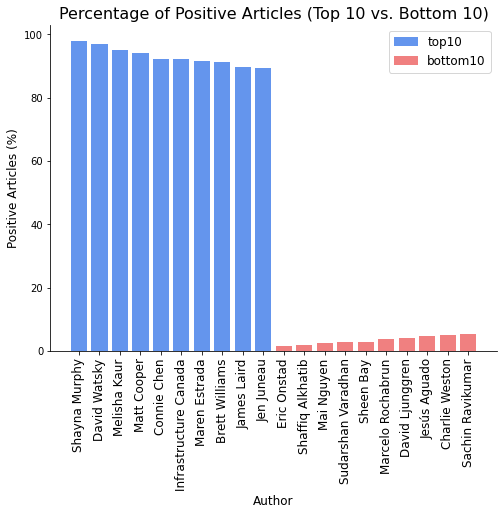

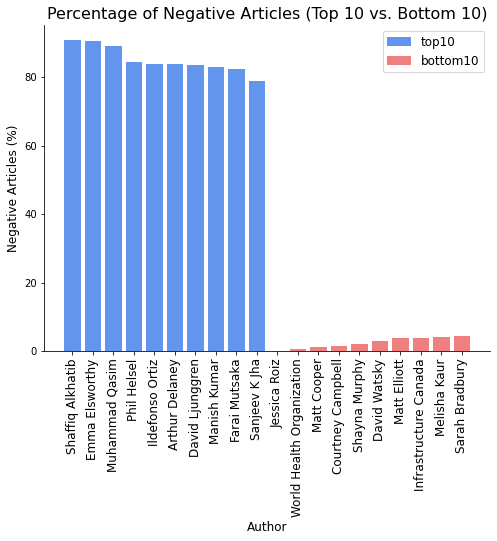

In [51]:
sentiment_compare('Author', author_list, True, pos_neg='positive')
sentiment_compare('Author', author_list, True, pos_neg='negative')

The categorical sentiment shows a large variation across different authors. We can also check on the numeric sentiment score:

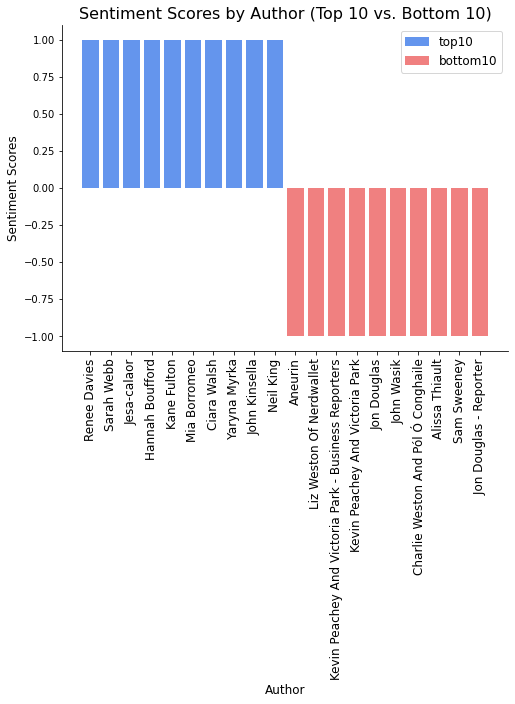

In [52]:
sentiment_compare('Author', author_list, False)

The graphs show that some authors tend to have certain sentiment tendency for the articles they write. In the extreme of both ends, writers are having extreme sentiment scores for all the articles they writes. Note that the largest "author" names are actually institutions, but as shown in the above graphs, it is human writers who are more likely to have extreme tendency in sentiment.

I will now save the processed data for later use. Due to the limitation of my RAM space and efficiency of my test, I will only use 25% of the data to do my modeling, which is still more than 400,000 articles.

In [4]:
#extract 25% of the sample, stratified by "Sentiment_Body"
covid_df = covid_df.groupby('Sentiment_Body', group_keys=False).apply(lambda x: x.sample(frac=0.25))
#Save to .csv file
covid_df.to_csv('data/Covid_Dataset_Cleaned.csv')

To conclude this notebook, I have done some preliminary exploration of the dataset and handled some of the missing values. There seems to be some variation on sentiments for articles in different countries and published on different dates, but the larger variance appears to be across the dimension of news sources and authors. Some sources/authors tend to have extreme average sentiment scores for the articles they wrote. 

In my next notebook, I will train a Word2Vec embedding with neural network, which will be used in my modeling process. The actual modeling work will be shown in my third and final notebook.